In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.autograd import *
import os
import matplotlib.pyplot as plt
import pickle
from torchvision.models import resnet18
import numpy as np
from resnet import *
from collections import OrderedDict

# Define the device to use for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations for the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Load ResNet18 model
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print('==> Loading basic ResNet model..')
net_basic = ResNet18()
net_basic = net_basic.to(device)
if device == 'cuda':
    net_basic = torch.nn.DataParallel(net_basic)
    cudnn.benchmark = True

file_path = "/home/pratyush/pratyushg/resnetTraining/resnet18_cifar10_basicTraining.pth"
state_dict = torch.load(file_path)

# Create a new state dictionary without the 'module.' prefix
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        name = k[7:]  # remove 'module.' prefix
    else:
        name = k
    new_state_dict[name] = v

net_basic.load_state_dict(new_state_dict)

#Load ResNet18 model with FGSM adversarial training
print('==> Loading FGSM-trained model..')
net_fgsm = ResNet18()
net_fgsm = net_fgsm.to(device)
if device == 'cuda':
    net_fgsm = torch.nn.DataParallel(net_fgsm)
    cudnn.benchmark = True

file_path = "/home/pratyush/pratyushg/resnetTraining/resnet18_cifar10_fgsmTraining.pth"
state_dict = torch.load(file_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        name = k[7:]  # remove 'module.' prefix
    else:
        name = k
    new_state_dict[name] = v

net_fgsm.load_state_dict(new_state_dict)

#Load ResNet18 model with PGD adversarial training
print('==> Loading PGD-trained model..')
net_pgd = ResNet18()
net_pgd = net_pgd.to(device)
if device == 'cuda':
    net_pgd = torch.nn.DataParallel(net_pgd)
    cudnn.benchmark = True

file_path = "/home/pratyush/pratyushg/resnetTraining/resnet18_cifar10_pgdTraining_iter20.pth"
state_dict = torch.load(file_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        name = k[7:]  # remove 'module.' prefix
    else:
        name = k
    new_state_dict[name] = v

net_pgd.load_state_dict(new_state_dict)

#Load ResNet18 model with Chaos Loss minimization training
print('==> Loading ChaosLoss Minimization model..')
net_chaosLoss = ResNet18()
net_chaosLoss = net_chaosLoss.to(device)
if device == 'cuda':
    net_chaosLoss = torch.nn.DataParallel(net_chaosLoss)
    cudnn.benchmark = True

file_path = "/home/pratyush/pratyushg/resnetTraining/resnet18_cifar10_chaos_regularized_pgd_torchattacks_lambdaChaos0.8_epoch100_lr0.01.pth"
state_dict = torch.load(file_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('resnet18.'):
        name = k[9:]  # remove 'module.' prefix
    else:
        name = k
    new_state_dict[name] = v

net_chaosLoss.load_state_dict(new_state_dict)

# Define a function to calculate the susceptibility ratio
def susceptibility_ratio(net, x, delta_x_adv):
    x = x.to(device)
    delta_x_adv = delta_x_adv.to(device)
    
    # Ensure the model is in evaluation mode
    net.eval()
    
    # Calculate h(θ; x_i)
    output_x = net(x)
    
    # Calculate h(θ; x_i + δx_adv)
    output_x_adv = net(x + delta_x_adv)
    
    # Calculate the susceptibility ratio
    num = torch.norm(output_x - output_x_adv, p=2)
    denom = torch.norm(delta_x_adv, p=2)
    
    susceptibility = torch.exp(num / denom)
    return susceptibility.item()

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Define a small adversarial perturbation
epsilon = 0.01
delta_x_adv = epsilon * torch.sign(torch.randn_like(images)) #FGSM Attack

# Calculate the susceptibility ratio for the batch
susceptibility_basic_model = susceptibility_ratio(net_basic, images, delta_x_adv)
susceptibility_fgsm_model = susceptibility_ratio(net_fgsm, images, delta_x_adv)
susceptibility_pgd_model = susceptibility_ratio(net_pgd, images, delta_x_adv)
susceptibility_chaosLoss_model = susceptibility_ratio(net_chaosLoss, images, delta_x_adv)
print(f'Susceptibility Ratio of Basic Model: {susceptibility_basic_model}')
print(f'Susceptibility Ratio of Adversarially Trained (FGSM) Model: {susceptibility_fgsm_model}')
print(f'Susceptibility Ratio of Adversarially Trained (PGD) Model: {susceptibility_pgd_model}')
print(f'Susceptibility Ratio of Chaos-loss trained Model: {susceptibility_chaosLoss_model}')


Files already downloaded and verified
Files already downloaded and verified
==> Loading basic ResNet model..
==> Loading FGSM-trained model..
==> Loading PGD-trained model..
==> Loading ChaosLoss Minimization model..
Susceptibility Ratio of Basic Model: 2.5948617458343506
Susceptibility Ratio of Adversarially Trained (FGSM) Model: 1.0795212984085083
Susceptibility Ratio of Adversarially Trained (PGD) Model: 1.2488479614257812
Susceptibility Ratio of Chaos-loss trained Model: 1.3951265811920166


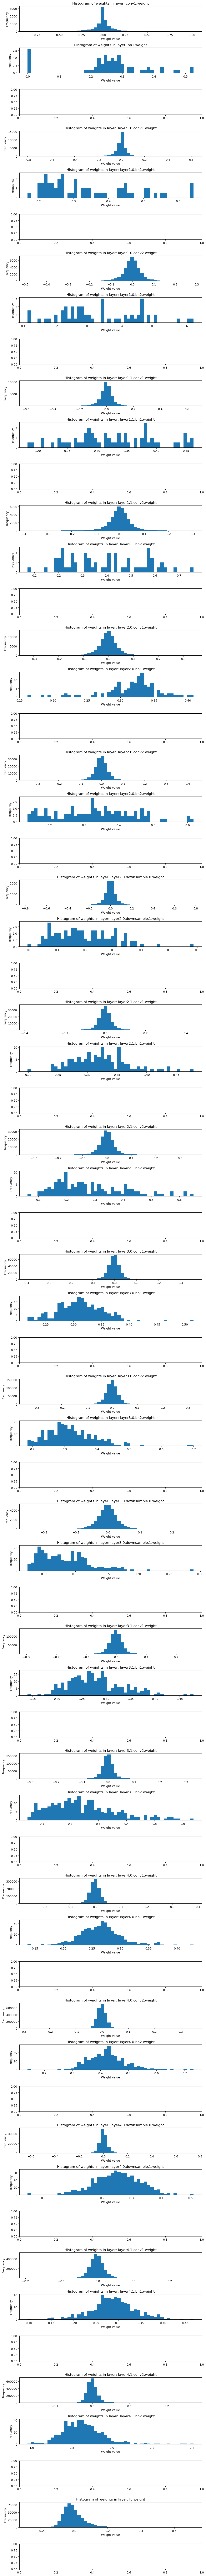

In [2]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Alternatively, initialize a new ResNet18 model
# model = models.resnet18(pretrained=False)

# Function to plot histograms of weights
def plot_weight_histograms(model):
    # Create a figure with subplots for each layer
    num_layers = sum(1 for _ in model.parameters())
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, num_layers * 2))
    
    if num_layers == 1:
        axes = [axes]

    for i, (name, param) in enumerate(model.named_parameters()):
        if 'weight' in name:
            axes[i].hist(param.data.cpu().numpy().flatten(), bins=50)
            axes[i].set_title(f'Histogram of weights in layer: {name}')
            axes[i].set_xlabel('Weight value')
            axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot histograms of the weights
plot_weight_histograms(model)


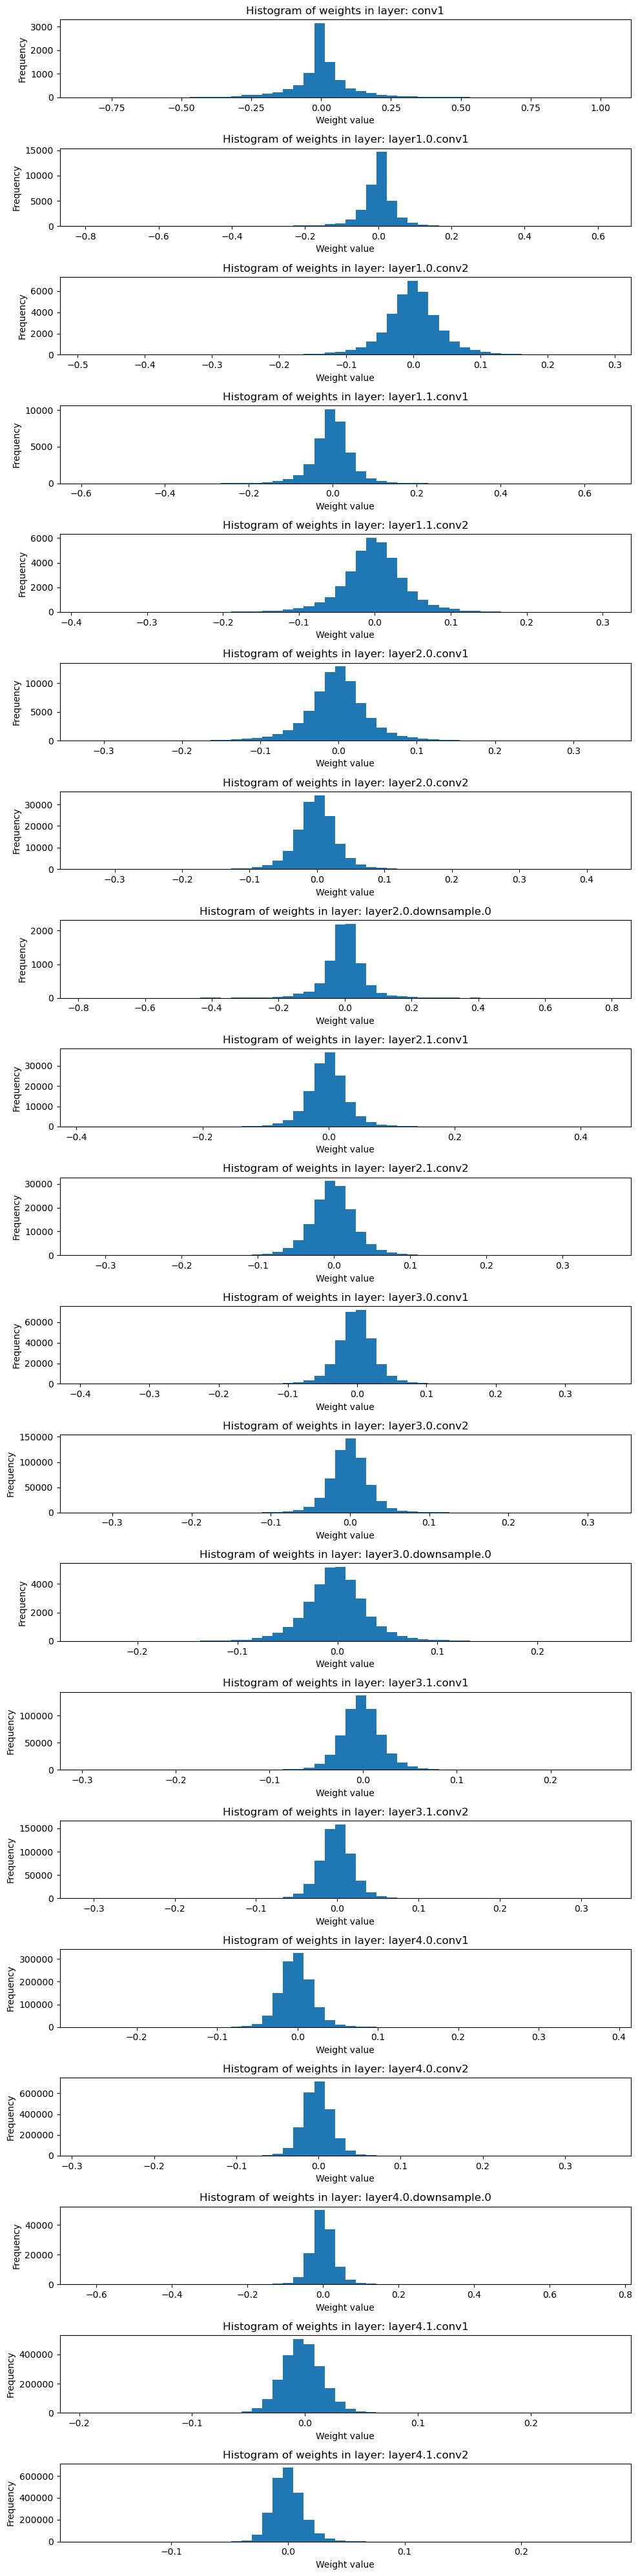

In [3]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Alternatively, initialize a new ResNet18 model
# model = models.resnet18(pretrained=False)

# Function to plot histograms of weights for convolutional layers
def plot_conv_weight_histograms(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append((name, module))

    num_layers = len(conv_layers)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, num_layers * 2))
    
    if num_layers == 1:
        axes = [axes]

    for i, (name, layer) in enumerate(conv_layers):
        weight = layer.weight.data.cpu().numpy().flatten()
        axes[i].hist(weight, bins=50)
        axes[i].set_title(f'Histogram of weights in layer: {name}')
        axes[i].set_xlabel('Weight value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot histograms of the weights for convolutional layers
plot_conv_weight_histograms(model)


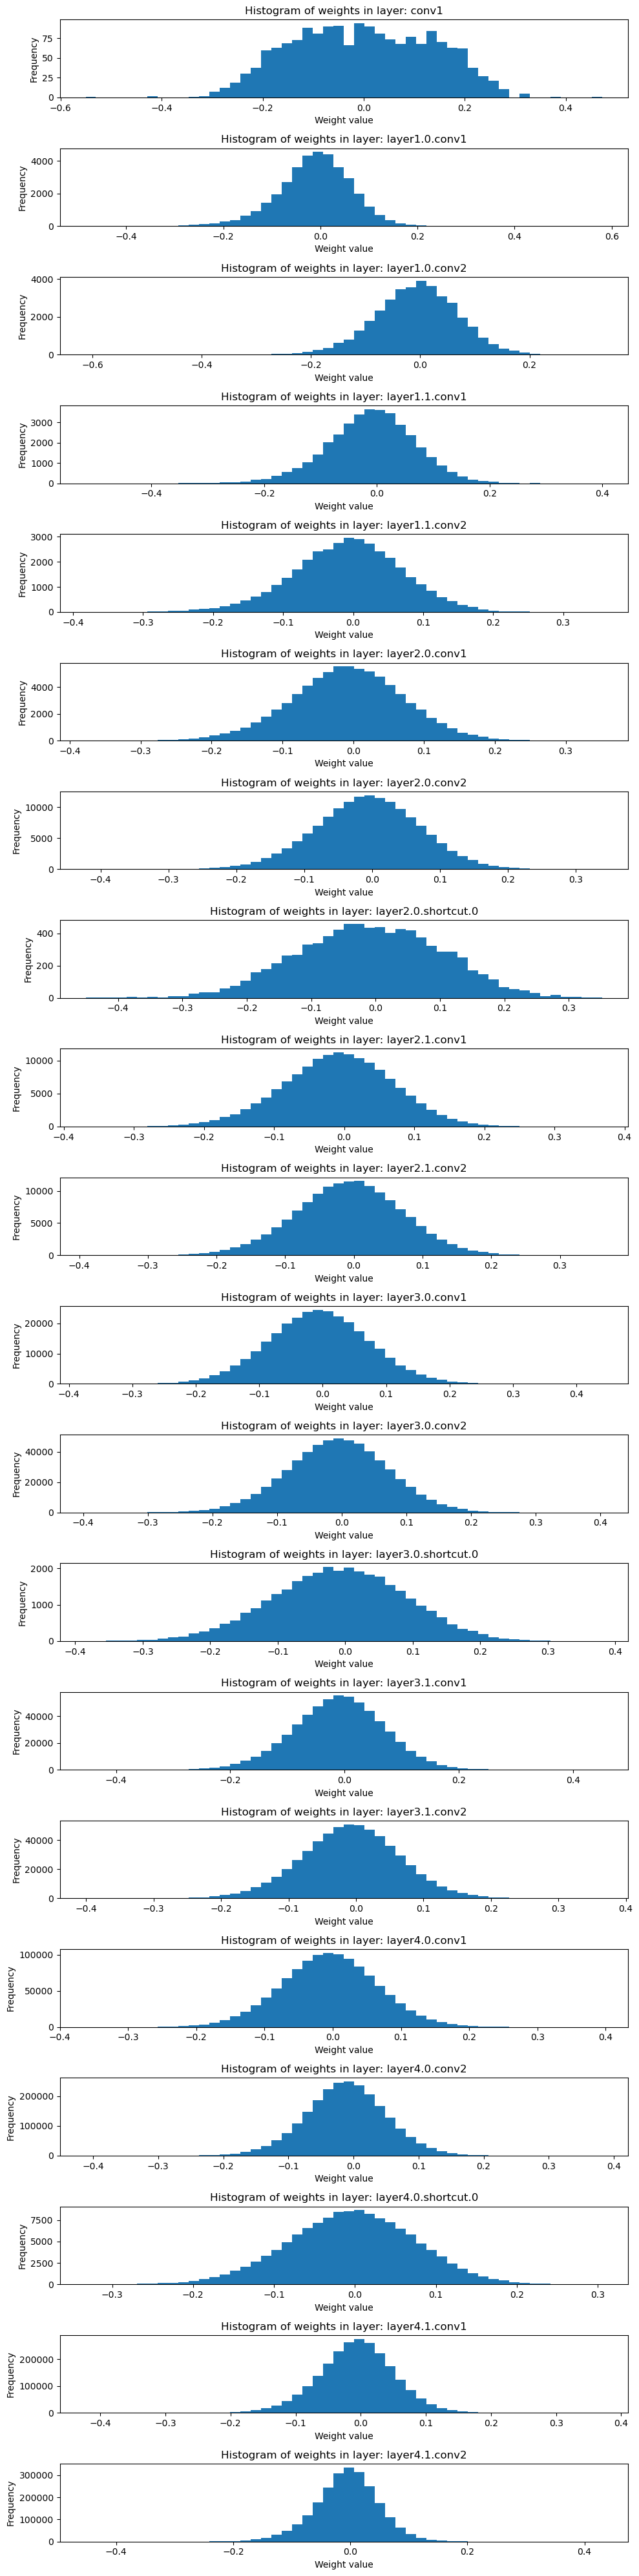

In [4]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Load the pre-trained ResNet18 model
model = net_chaosLoss

# Alternatively, initialize a new ResNet18 model
# model = models.resnet18(pretrained=False)

# Function to plot histograms of weights for convolutional layers
def plot_conv_weight_histograms(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append((name, module))

    num_layers = len(conv_layers)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, num_layers * 2))
    
    if num_layers == 1:
        axes = [axes]

    for i, (name, layer) in enumerate(conv_layers):
        weight = layer.weight.data.cpu().numpy().flatten()
        axes[i].hist(weight, bins=50)
        axes[i].set_title(f'Histogram of weights in layer: {name}')
        axes[i].set_xlabel('Weight value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot histograms of the weights for convolutional layers
plot_conv_weight_histograms(model)


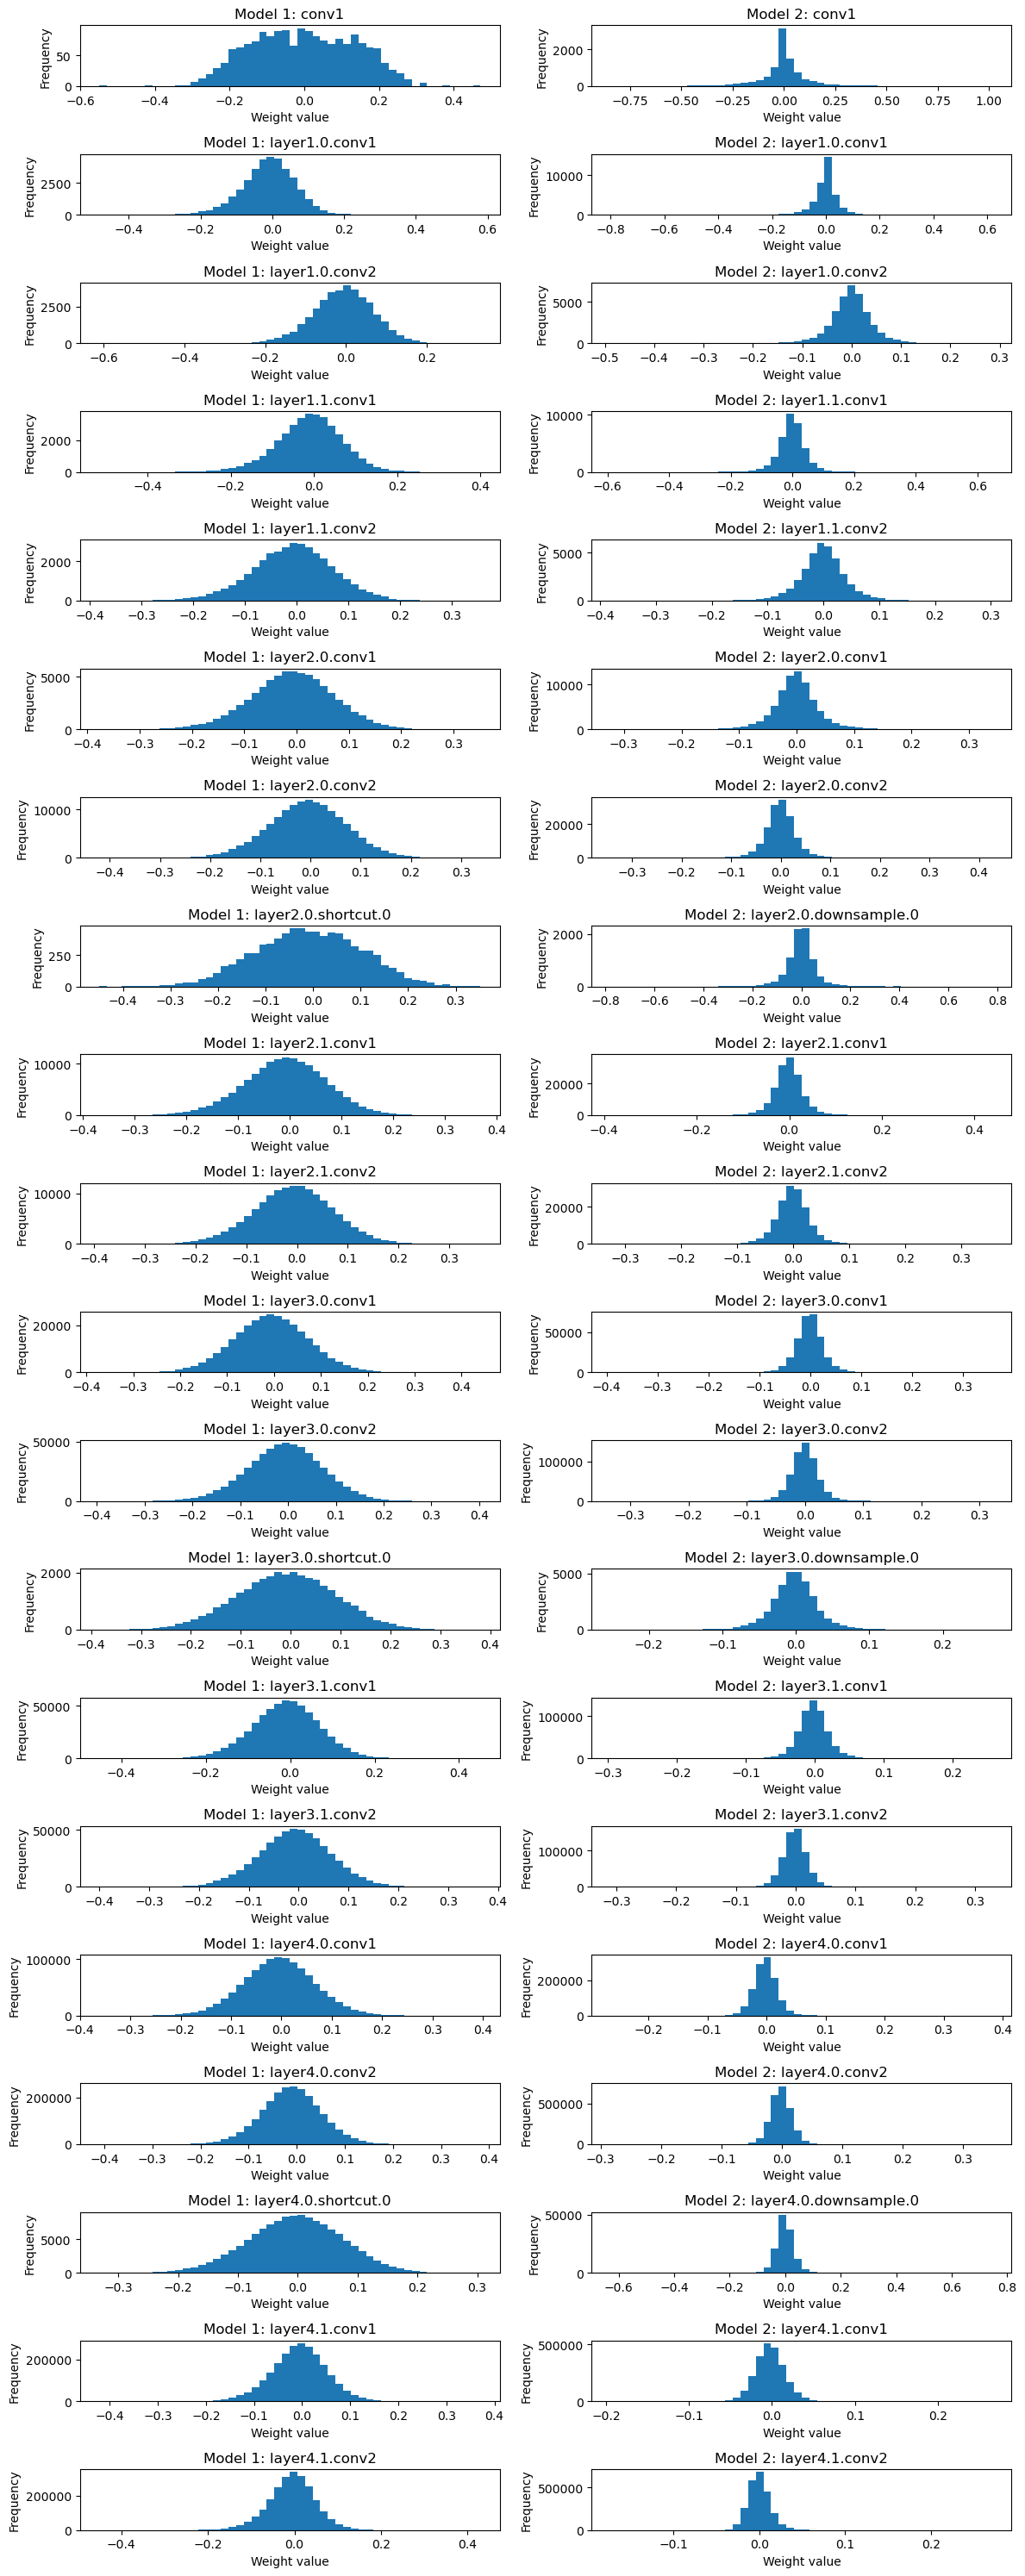

In [9]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Load your models
model1 = net_chaosLoss  # Assuming this is defined somewhere in your code
model2 = net_basic

# Function to get convolutional layers
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

# Function to plot histograms of weights for convolutional layers of two models
def plot_conv_weight_histograms(model1, model2):
    conv_layers1 = get_conv_layers(model1)
    conv_layers2 = get_conv_layers(model2)
    
    num_layers = len(conv_layers1)
    fig, axes = plt.subplots(num_layers, 2, figsize=(12, num_layers * 1.5))

    for i, ((name1, layer1), (name2, layer2)) in enumerate(zip(conv_layers1, conv_layers2)):
        weight1 = layer1.weight.data.cpu().numpy().flatten()
        weight2 = layer2.weight.data.cpu().numpy().flatten()

        axes[i, 0].hist(weight1, bins=50)
        axes[i, 0].set_title(f'Model 1: {name1}')
        axes[i, 0].set_xlabel('Weight value')
        axes[i, 0].set_ylabel('Frequency')

        axes[i, 1].hist(weight2, bins=50)
        axes[i, 1].set_title(f'Model 2: {name2}')
        axes[i, 1].set_xlabel('Weight value')
        axes[i, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot histograms of the weights for convolutional layers of both models
plot_conv_weight_histograms(model1, model2)
